In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as C
import astropy.units as U
from astropy.convolution import Gaussian2DKernel
import galsim
from astropy.convolution import convolve_fft
from astropy.visualization import (MinMaxInterval, LinearStretch, SqrtStretch,
                                   LogStretch, AsinhStretch, ImageNormalize)
from morphsed import Galaxy, AGN, Galaxy3D
from astropy.modeling.models import Sersic2D
from morphsed.plot import plotIFU
import morphsed.sed_interp as SEDs
import morphsed.emission_lines as ELs
import time,csv,lmfit
from csst_slitless_calibration.IFUDisperser.disperser import MockSpectrum, IFUDisperser
U_SPEC_WAVE = U.erg/(U.s * U.cm**2 * U.AA)
from csst_slitless_calibration.data import LINES, DATADIR
from astropy.modeling.functional_models import Sersic1D
from astropy.visualization import make_lupton_rgb

In [2]:
wavelength=np.logspace( np.log10(3000), np.log10(10000), 2001) # wavelength grid

## parameters of Telescope and instrument
p_size  = 0.074 # in arcsec/pixel
aper    = 2     # im meter

## parameters of PSF
N_psf = 31
psf = galsim.Gaussian(fwhm=0.39)
psf_image = psf.drawImage(wcs=galsim.PixelScale(p_size), nx=N_psf, ny=N_psf).array

# parameters of the observation and the object
exptime  = 150              # in s
nxi, nyi = 9232, 9216       # size of the grism image (CSST size), i means image
xc, yc   = 4000.75, 4000.25 # center position of the object, x and y start from 0
nxs, nys = 150, 150         # stamp size, s means stamp

# ixmin, iymin is the left,bottom corner of the stamp
#   the object is also (roughly) at the center of the stamp image
ixmin = int(int(xc) - (nxs-1)/2)
iymin = int(int(yc) - (nys-1)/2)

# grism disperser config file
AXECONF = DATADIR/'cycle3/CSST_GV2.conf'

In [3]:
def alpha_tanh(r_3d, r_in, r_out, alpha, theta_out):
    theta_out_rad = theta_out*np.pi/180.
    return theta_out_rad*hypotan(r_3d, r_in, r_out, alpha, theta_out_rad)*np.power(0.5*(r_3d/r_out+1.),alpha)

def hypotan(r_3d, r_in, r_out, alpha, theta_out_rad):
    CDEF = 0.23
    A = 2.*CDEF/(np.abs(theta_out_rad)+CDEF)-1.00001
    B = (2.-np.arctanh(A))*r_out/(r_out-r_in)
    return 0.5*np.tanh(B*(r_3d/r_out-1.)+2.)+0.5

def R_2d(x,y):
    return (np.sqrt(x**2+y**2))

def R_3d(x,y,PA,i):
    phi = PA*np.pi/180.
    dis_proj_square = np.abs(np.cos(phi)*y-np.sin(phi)*x)**2
    return np.sqrt(R_2d(x,y)**2+(1./np.cos(i*np.pi/180.)-1)*dis_proj_square)

def xy_3d(x,y,PA,i):
    phi = PA*np.pi/180.
    dis_proj = np.cos(phi)*y-np.sin(phi)*x
    projvec = (1./np.cos(i*np.pi/180.)-1.)*dis_proj
    return x-projvec*np.sin(phi),y+projvec*np.cos(phi)

def R_fourier(x,y,m,am,theta_m,PA,i):
    lower = y < 0.
    phi_map = np.arccos(x/R_2d(x,y))
    phi_map[lower] = 2.*np.pi-phi_map[lower]
    return R_3d(x,y,PA,i)*(1.+am*np.cos(m*(phi_map+theta_m*np.pi/180.)))

In [4]:
ny,nx=(150,150)
xcen = 83.
ycen = 83.
PA = 45.
i = 30.
r_in = 0.
r_out = 25.
alpha = 1.
theta_out = 30.
m = 1
am = 0.93
i_arm = 0.
theta_m = 135.

xaxis = np.arange(nx)
yaxis = np.arange(ny)

xmesh, ymesh = np.meshgrid(xaxis, yaxis)
x_p = xmesh + 0.5 - xcen
y_p = ymesh + 0.5 - ycen
r_2d = R_2d(x_p,y_p)
r_3d = R_3d(x_p,y_p,PA,i)
theta_r = alpha_tanh(r_3d, r_in, r_out, alpha, theta_out)
#theta_r = 0.
x_p,y_p = xy_3d(x_p,y_p,PA,i)
x_i = x_p*np.cos(theta_r) + y_p*np.sin(theta_r)
y_i = -x_p*np.sin(theta_r) + y_p*np.cos(theta_r)
r_3d_i = R_fourier(x_i,y_i,m,am,theta_m,PA,i_arm)

s1 = Sersic1D(amplitude=1, r_eff=5)
mass_map_11 = 3e10*s1(r_2d)/np.sum(s1(r_2d))
s1 = Sersic1D(amplitude=1, r_eff=75)
mass_map_12 = 7e10*s1(r_3d_i)/np.sum(s1(r_3d_i))


#r_2d_i = 

In [5]:
ny,nx=(150,150)
xcen = 67.
ycen = 67.
PA = 45.
i = 30.
r_in = 0.
r_out = 25.
alpha = 1.
theta_out = 90.
m = 1
am = 0.93
i_arm = 0.
theta_m = 45.

xaxis = np.arange(nx)
yaxis = np.arange(ny)

xmesh, ymesh = np.meshgrid(xaxis, yaxis)
x_p = xmesh + 0.5 - xcen
y_p = ymesh + 0.5 - ycen
r_2d = R_2d(x_p,y_p)
r_3d = R_3d(x_p,y_p,PA,i)
theta_r = alpha_tanh(r_3d, r_in, r_out, alpha, theta_out)
#theta_r = 0.
x_p,y_p = xy_3d(x_p,y_p,PA,i)
x_i = x_p*np.cos(theta_r) + y_p*np.sin(theta_r)
y_i = -x_p*np.sin(theta_r) + y_p*np.cos(theta_r)
r_3d_i = R_fourier(x_i,y_i,m,am,theta_m,PA,i_arm)

s1 = Sersic1D(amplitude=1, r_eff=5)
mass_map_21 = 6e10*s1(r_2d)/np.sum(s1(r_2d))
s1 = Sersic1D(amplitude=1, r_eff=75)
mass_map_22 = 1.4e11*s1(r_3d_i)/np.sum(s1(r_3d_i))

x_p = xmesh + 0.5 - 75
y_p = ymesh + 0.5 - 75
r_2d = R_2d(x_p,y_p)
s1 = Sersic1D(amplitude=1, r_eff=30, n=1)
mass_map_3 = 1e11*s1(r_2d)/np.sum(s1(r_2d))

#r_2d_i = 

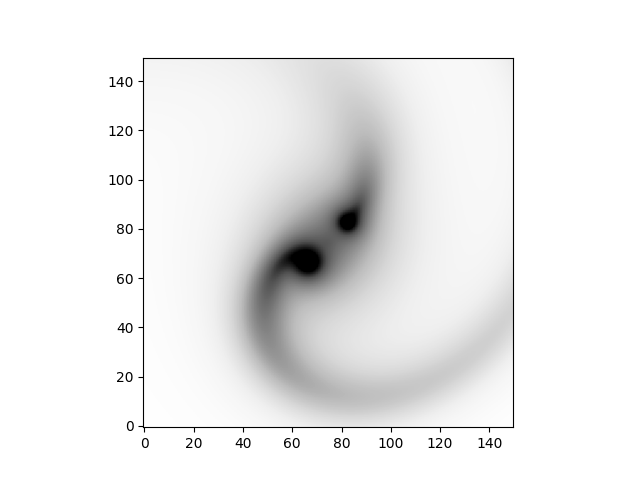

In [8]:
sky_std = np.std(mass_map_11+mass_map_12)
norm=ImageNormalize(vmin=0,vmax=10*sky_std,stretch=AsinhStretch())
plt.imshow(mass_map_11 + mass_map_12+ mass_map_21 + mass_map_22+mass_map_3, origin='lower',norm=norm, cmap='Greys',)
plt.savefig('/Users/liruancun/Desktop/exp.png',dpi=200,bbox_inches='tight')
plt.show()

In [7]:
Mygalaxy = Galaxy3D(mass = 1e11,z=0.03,ebv_G=0.07)
Mygalaxy.imshape = (150,150)
age = {'type': "const", 'paradic':{'value': 1}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.25}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_arbsubC('bulge',mass_map_11,age,Z,f_cont,Av,sigma,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 0.3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.75}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_arbsubC('arm',mass_map_12,age,Z,f_cont,Av,sigma,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 9}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.05}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_arbsubC('bulge',mass_map_21,age,Z,f_cont,Av,sigma,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.35}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_arbsubC('arm',mass_map_22,age,Z,f_cont,Av,sigma,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.35}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
sigma = {'type': "const", 'paradic':{'value': 150}}
Mygalaxy.add_arbsubC('arm',mass_map_3,age,Z,f_cont,Av,sigma,arbi_para={'func':'Users'})
psfFWHM=1.44
psf = Gaussian2DKernel(psfFWHM, x_size=15, y_size=15)
psf.normalize()
r_curve = {
    'function_name':'arctan',
    'params':{'v0':0.,'vc':220.,'r0':0.,'rt':20.,},
}
geometry = {
            'xcen' : 75.,
            'ycen' : 75., # in pix
            'i'  :  45.,      # in degree, arccos(axis ratio of disk)
            'PA' :  57.3, # in degree 90+ position angle of disk
            'rotation_curve': r_curve, # {'function_name','params'}
        }
v_map = Mygalaxy.geometry_3D(geometry)
lines = [ELs.OII,ELs.NeIII,ELs.Hg,ELs.Hb,ELs.Ha,ELs.OIII_4959,ELs.OIII_5007,ELs.HeI,ELs.OI_6302,
         ELs.NII_6549,ELs.NII_6583,ELs.SII_6716,ELs.SII_6731]
amplist = []
mod = Sersic2D(amplitude = 1., r_eff = 35, n=1, x_0=50, y_0=50, ellip=1.-np.sqrt(0.75), theta=57.3*np.pi/180)
x,y = np.meshgrid(np.arange(150), np.arange(150))
sbp_line_fidutial =  mod(x, y)
sbp_line_fidutial *= 1./np.sum(sbp_line_fidutial)
with open("{0}/templates/line_test.csv".format(SEDs.DATA_PATH), mode='r') as infile:
    reader = csv.reader(infile)
    mydict = dict((rows[0],float(rows[1])) for rows in reader)
C_unit = mydict['SSP1C_unit']
for line in lines:
    if line['name'] == 'NaD':
        amplist.append(sbp_line_fidutial*mydict['HeIa1amplitude']/C_unit)
    else:
        amplist.append(sbp_line_fidutial*mydict['{0}n1amplitude'.format(line['name'])]/C_unit)
sigmap = np.ones((150,150))*3.5*SEDs.c/ELs.OIII_5007['wave']

In [8]:
start_t = time.time()
IFU = Mygalaxy.generate_SED_IFU(wavelength,resolution=10, highres=False)
EL_IFU = Mygalaxy.emission_line(wavelength,lines,amplist,sigmap)
tot_IFU = IFU + EL_IFU
IFU_cov = tot_IFU.copy()
for loop in range(len(wavelength)):
    IFU_cov[:,:,loop] = convolve_fft(tot_IFU[:,:,loop],psf) 
stop_t = time.time()

print ("elapse time {0:.2f} s".format(stop_t-start_t))

elapse time 63.76 s


In [10]:
Mygalaxy2d = Galaxy(mass = 1e11,z=0.03,ebv_G=0.07)
Mygalaxy2d.imshape = (150,150)
age = {'type': "const", 'paradic':{'value': 1}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.25}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
Mygalaxy2d.add_arbsubC('bulge',mass_map_11,age,Z,f_cont,Av,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 0.3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.75}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
Mygalaxy2d.add_arbsubC('arm',mass_map_12,age,Z,f_cont,Av,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 9}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.05}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
Mygalaxy2d.add_arbsubC('bulge',mass_map_21,age,Z,f_cont,Av,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.35}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
Mygalaxy2d.add_arbsubC('arm',mass_map_22,age,Z,f_cont,Av,arbi_para={'func':'Users'})
age = {'type': "const", 'paradic':{'value': 3}}
Z = {'type': "const", 'paradic':{'value': 0.02}}
f_cont = {'type': "const", 'paradic':{'value': 0.35}}
Av = {'type': "const", 'paradic':{'value': 1.5}}
Mygalaxy2d.add_arbsubC('arm',mass_map_3,age,Z,f_cont,Av,arbi_para={'func':'Users'})
psfFWHM=1.44
psf = Gaussian2DKernel(psfFWHM, x_size=15, y_size=15)
psf.normalize()


In [13]:
Mygalaxy2d.shape = (150,150)
Mygalaxy2d.r_map=r_2d
image_u = Mygalaxy2d.generate_image('sloan_u',psf)
image_g = Mygalaxy2d.generate_image('sloan_g',psf)
image_z = Mygalaxy2d.generate_image('sloan_z',psf)

array([[33.54741347, 33.67811341, 33.73342637, ..., 33.87604603,
        33.80622167, 33.66495677],
       [33.68019505, 33.81097839, 33.86640985, ..., 34.02105055,
        33.95096001, 33.80950249],
       [33.73823614, 33.86913534, 33.92473138, ..., 34.09618005,
        34.02572125, 33.88399705],
       ...,
       [35.16950752, 35.29682872, 35.34727388, ..., 35.01339558,
        34.981335  , 34.86716433],
       [35.12836678, 35.25573273, 35.30623853, ..., 34.97219097,
        34.94014047, 34.82594314],
       [35.00750399, 35.1349028 , 35.18545313, ..., 34.85146924,
        34.81941021, 34.70518224]])

In [25]:
norm_u = 100000*image_u/np.sum(image_u)
norm_g = 100000*image_g/np.sum(image_g)
norm_z = 100000*image_z/np.sum(image_z)
image = make_lupton_rgb(norm_z, norm_g, norm_u, Q=10)
fig=plt.figure(figsize=(10,10))
plt.imshow(image,origin='lower')
plt.savefig('./rgb.png',dpi=200,bbox_inches='tight')
plt.close()

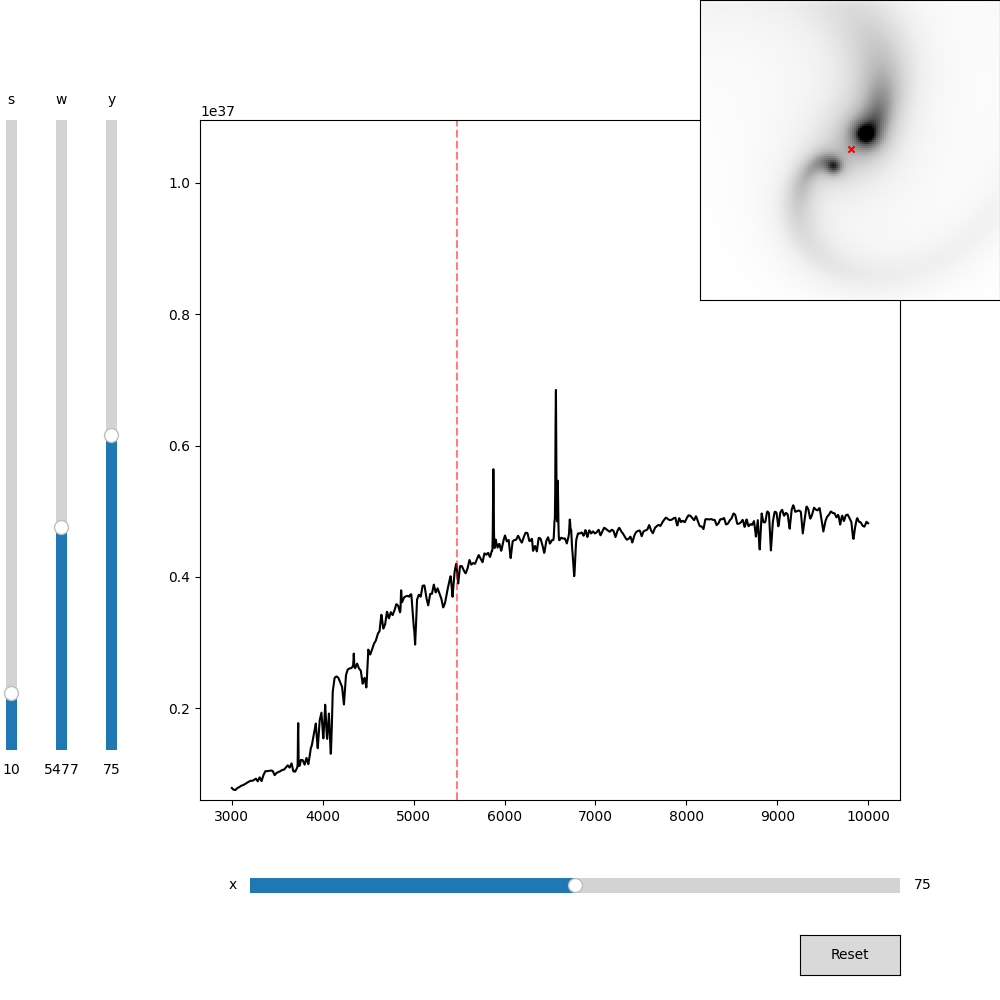

In [27]:
fig = plotIFU(wavelength,IFU_cov)
plt.show(block=False)

In [74]:
# init IFUDisperser
disperser = IFUDisperser(
  nx=nxi, ny=nyi,
  axeconf=AXECONF,
  aper=aper,
  psf=psf_image
)

In [75]:
for i in range(3):
    t0 = time.time()
    beams = disperser.get_spec_orders(
        wave=wavelength,
        ifu=IFU,
        ixmin=ixmin, iymin=iymin,
        exptime=exptime,
        psf=True,
        bin=3,
        debug=True,
        beams=['A']
    )
    print(f'calculate beams at {i} times in {time.time()-t0:.2f}s')

calculating dxdylam 3d for ((3925, 3925))+(150,150):3:A:3000.0:10000.0
	 in 11.47s
  prepare A in 11.47s
calculate A in 11.47s + 0.31s
calculate beams at 0 times in 11.78s
  prepare A in 0.00s
calculate A in 0.00s + 0.31s
calculate beams at 1 times in 0.31s
  prepare A in 0.00s
calculate A in 0.00s + 0.35s
calculate beams at 2 times in 0.35s


In [91]:
Mygalaxy.redshift

0.03

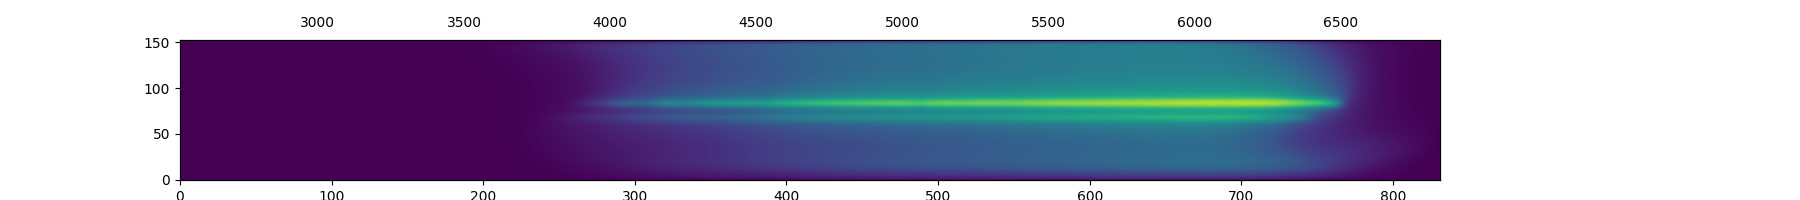

In [78]:
grism_image = beams['A']['beam']
sky_std = np.std(grism_image)
norm=ImageNormalize(vmin=0,vmax=10*sky_std,stretch=AsinhStretch())
if 'show grism beam':
    fig = plt.figure(figsize=(18,2))
        
    ax1 = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax1.xaxis.set_tick_params(labeltop=True)
    ax1.xaxis.set_tick_params(labelbottom=False)
    ax1.xaxis.set_tick_params(bottom=False)
    ax1.yaxis.set_tick_params(labelleft=False)
    ax1.yaxis.set_tick_params(left=False)
    xmin = beams['A']['debug']['xmin']
    xmax = beams['A']['debug']['xmax']
    lam_min = beams['A']['debug']['lam'][0]
    lam_max = beams['A']['debug']['lam'][-1]
    trans_func = lambda _: (_-xmin)/(xmax-xmin) * (lam_max-lam_min) + lam_min
    ax1.set_xlim(trans_func(0), trans_func(grism_image.shape[1]-1))

    ax = fig.add_axes([0.1,0.1, 0.7, 0.7])
    ax.imshow(grism_image, aspect='auto',origin='lower',norm=norm)
    ax.set_xlim(0, grism_image.shape[1]-1)
plt.savefig('./slitless.png',dpi=200,bbox_inches='tight')
plt.show(block=False)
time.sleep(2)
